In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pickle
from torchvision import datasets, transforms
from tqdm import tqdm
from copy import deepcopy
from collections import OrderedDict
import matplotlib.pyplot as plt


from utils import set_seed,get_device,get_loaders,clamp,get_label,get_loader,prepare_transforms,get_train_loader
from network import PreActResNet18
from train_utils import attack_pgd,evaluate_pgd,evaluate_standard,train_val_cycle

In [3]:
set_seed(42)

In [4]:
device = get_device()
device

'cuda'

In [5]:
model = PreActResNet18(num_classes=100).to(device)

print()

In [6]:
weight_decay = 5e-4
epsilon = 8
batch_size = 32
alpha = 2
loss_weight = 0.3
fgsm_step = 1
delta_init = 'random'

data_mean = (0.5071, 0.4865, 0.4409)
data_std = (0.2673, 0.2564, 0.2762)

mu = torch.tensor(data_mean).view(3, 1, 1).to(device)
std = torch.tensor(data_std).view(3, 1, 1).to(device)
upper_limit = ((1 - mu) / std)
lower_limit = ((0 - mu) / std)
epsilon = (epsilon / 255.) / std
alpha = (alpha / 255.) / std

if delta_init == 'previous':
    delta = torch.zeros(batch_size, 3, 32, 32).to(device)

prev_robust_acc = 0.

In [7]:
epochs = 20

acc_train_history = []
acc_pgd_val_history = []
acc_st_val_history = []

In [8]:
data_cases = ['base','reduce_easy','add_hard','add_random','reduce_random']
values = [[],[],[],[]]
history = dict(zip(data_cases,values))

In [9]:
hard_classes = [13,35,55,72,96,10,44,65,74,4]
easy_classes = [8,9,20,87,94,21,41,39,53,68]

BASE case (data without modification)

In [14]:
train_loader, test_loader = get_loaders(augments=[False,False])
model = PreActResNet18(num_classes=100).to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4,weight_decay=weight_decay)
scaler = torch.cuda.amp.GradScaler()

Files already downloaded and verified
Files already downloaded and verified


In [22]:
history['base'] = train_val_cycle(model,train_loader,test_loader,optimizer,scaler,epochs,device,delta_init,epsilon,alpha)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch started
training...
Evaluate on attacs


train acc: 0.149 test st_acc: 0.2089 test at_acc: 0.2068:   5%|▌         | 1/20 [02:19<44:19, 139.99s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.305 test st_acc: 0.3329 test at_acc: 0.3271:  10%|█         | 2/20 [04:40<42:09, 140.55s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.413 test st_acc: 0.4312 test at_acc: 0.4228:  15%|█▌        | 3/20 [07:01<39:48, 140.48s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.496 test st_acc: 0.4873 test at_acc: 0.4753:  20%|██        | 4/20 [09:21<37:24, 140.29s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.552 test st_acc: 0.5165 test at_acc: 0.5053:  25%|██▌       | 5/20 [11:41<35:03, 140.21s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.602 test st_acc: 0.535 test at_acc: 0.5217:  30%|███       | 6/20 [14:01<32:41, 140.09s/it] 

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.644 test st_acc: 0.5488 test at_acc: 0.5346:  35%|███▌      | 7/20 [16:21<30:20, 140.06s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.692 test st_acc: 0.5518 test at_acc: 0.5342:  40%|████      | 8/20 [18:41<28:02, 140.23s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.731 test st_acc: 0.5546 test at_acc: 0.5361:  45%|████▌     | 9/20 [21:02<25:42, 140.23s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.769 test st_acc: 0.5564 test at_acc: 0.5359:  50%|█████     | 10/20 [23:22<23:22, 140.21s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.806 test st_acc: 0.5467 test at_acc: 0.5254:  55%|█████▌    | 11/20 [25:45<21:10, 141.17s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.837 test st_acc: 0.5418 test at_acc: 0.5202:  60%|██████    | 12/20 [28:11<18:59, 142.47s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.857 test st_acc: 0.5507 test at_acc: 0.5268:  65%|██████▌   | 13/20 [30:36<16:44, 143.50s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.883 test st_acc: 0.5369 test at_acc: 0.5125:  70%|███████   | 14/20 [33:02<14:25, 144.27s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.894 test st_acc: 0.5472 test at_acc: 0.5212:  75%|███████▌  | 15/20 [35:29<12:05, 145.10s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.91 test st_acc: 0.5391 test at_acc: 0.5138:  80%|████████  | 16/20 [37:56<09:42, 145.65s/it] 

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.916 test st_acc: 0.5298 test at_acc: 0.4995:  85%|████████▌ | 17/20 [40:23<07:17, 145.99s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.924 test st_acc: 0.5243 test at_acc: 0.4964:  90%|█████████ | 18/20 [42:50<04:52, 146.23s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.931 test st_acc: 0.5301 test at_acc: 0.5012:  95%|█████████▌| 19/20 [45:16<02:26, 146.31s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.937 test st_acc: 0.5253 test at_acc: 0.4969: 100%|██████████| 20/20 [47:43<00:00, 143.18s/it]

Evaluate on clear


In [28]:
import numpy as np


# Load
history_base = np.load('history_base.npy',allow_pickle='TRUE').item()['base']
history_easy = np.load('history1.npy',allow_pickle='TRUE').item()['reduce_easy']

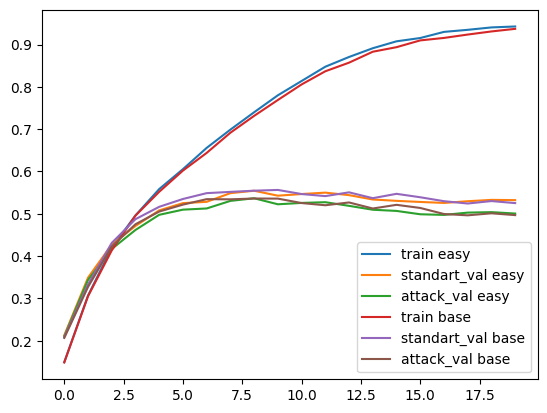

In [32]:
for key,value in history_easy.items():
    plt.plot(range(epochs),value,label=str(key)+' easy')

for key,value in history_base.items():
    plt.plot(range(epochs),value,label=str(key)+' base')
    
plt.legend()

Reduce easy classes

In [78]:
model = PreActResNet18(num_classes=100).to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4,weight_decay=weight_decay)
scaler = torch.cuda.amp.GradScaler()

In [79]:
random_classes = list(np.random.randint(0,100,10))
random_classes

[25, 88, 59, 40, 28, 14, 44, 64, 88, 70]

In [80]:
#we need new train_loader
data_dir='cifar-100'
train_transform, test_transform = prepare_transforms(augments=[False,False])

train_dataset = datasets.CIFAR100(data_dir, train=True, transform=train_transform, download=True)
test_dataset = datasets.CIFAR100(data_dir, train=False, transform=test_transform, download=True)
X_all,y_all = train_dataset.data, torch.LongTensor(train_dataset.targets)

X_all_sampled, y_all_sampled = [], []

for c in torch.unique(y_all):
    X_all_c, y_all_c = X_all[y_all==c], y_all[y_all==c]

    num_samples = len(X_all_c)
    sampled_indices = torch.randperm(num_samples)[:num_samples// (1 + int(c in random_classes))] #change to easy/random
    X_all_sampled.append(X_all_c[sampled_indices])
    y_all_sampled.append(y_all_c[sampled_indices]) 
    
X_all_sampled = np.concatenate(X_all_sampled, axis=0)
y_all_sampled = list(torch.cat(y_all_sampled, dim=0).numpy())

X_all_sampled.shape

Files already downloaded and verified
Files already downloaded and verified


(47750, 32, 32, 3)

In [81]:
train_loader = get_train_loader(data_dir, X_all_sampled, y_all_sampled,
                    batch_size, augment=False, shuffle=True)

Files already downloaded and verified


In [82]:
history['reduce_random'] = train_val_cycle(model,train_loader,test_loader,optimizer,scaler,epochs,device,delta_init,epsilon,alpha)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch started
training...
Evaluate on attacs


train acc: 0.147 test st_acc: 0.2125 test at_acc: 0.2105:   5%|▌         | 1/20 [01:45<33:29, 105.75s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.29 test st_acc: 0.3102 test at_acc: 0.3056:  10%|█         | 2/20 [03:32<31:56, 106.45s/it] 

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.394 test st_acc: 0.3821 test at_acc: 0.374:  15%|█▌        | 3/20 [05:19<30:15, 106.77s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.468 test st_acc: 0.4297 test at_acc: 0.4203:  20%|██        | 4/20 [07:06<28:28, 106.79s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.535 test st_acc: 0.4786 test at_acc: 0.4694:  25%|██▌       | 5/20 [08:53<26:43, 106.89s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.586 test st_acc: 0.5001 test at_acc: 0.488:  30%|███       | 6/20 [10:40<24:56, 106.86s/it] 

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.633 test st_acc: 0.5103 test at_acc: 0.498:  35%|███▌      | 7/20 [12:26<23:05, 106.59s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.678 test st_acc: 0.5254 test at_acc: 0.5107:  40%|████      | 8/20 [14:13<21:19, 106.64s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.725 test st_acc: 0.5275 test at_acc: 0.5116:  45%|████▌     | 9/20 [16:00<19:33, 106.66s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.865 test st_acc: 0.527 test at_acc: 0.5042:  65%|██████▌   | 13/20 [23:06<12:26, 106.65s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.889 test st_acc: 0.5199 test at_acc: 0.498:  70%|███████   | 14/20 [24:52<10:39, 106.55s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.904 test st_acc: 0.5142 test at_acc: 0.4885:  75%|███████▌  | 15/20 [26:39<08:53, 106.63s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.918 test st_acc: 0.5079 test at_acc: 0.4831:  80%|████████  | 16/20 [28:26<07:06, 106.63s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.929 test st_acc: 0.5109 test at_acc: 0.4858:  85%|████████▌ | 17/20 [30:12<05:19, 106.57s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.935 test st_acc: 0.5176 test at_acc: 0.4923:  90%|█████████ | 18/20 [31:59<03:33, 106.61s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.944 test st_acc: 0.5009 test at_acc: 0.4748:  95%|█████████▌| 19/20 [33:45<01:46, 106.55s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.947 test st_acc: 0.5044 test at_acc: 0.4825: 100%|██████████| 20/20 [35:31<00:00, 106.59s/it]

Evaluate on clear


In [83]:
np.save('history_reduce_random.npy', history) 

add hard samples

In [84]:
X_all_sampled, y_all_sampled = [], []

for c in torch.unique(y_all):
    X_all_c, y_all_c = X_all[y_all==c], y_all[y_all==c]

    num_samples = len(X_all_c)
    sampled_indices = torch.randperm(num_samples)
    if c in random_classes: #change to hard/random
        sampled_indices = torch.hstack([sampled_indices,torch.randperm(num_samples)[:num_samples//2]])
    X_all_sampled.append(X_all_c[sampled_indices])
    y_all_sampled.append(y_all_c[sampled_indices]) 
    
X_all_sampled = np.concatenate(X_all_sampled, axis=0)
y_all_sampled = list(torch.cat(y_all_sampled, dim=0).numpy())

X_all_sampled.shape

(52250, 32, 32, 3)

In [ ]:
train_loader = get_train_loader(data_dir, X_all_sampled, y_all_sampled,
                    batch_size, augment=False, shuffle=True)

Files already downloaded and verified


In [ ]:
model = PreActResNet18(num_classes=100).to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4,weight_decay=weight_decay)
scaler = torch.cuda.amp.GradScaler()

In [ ]:
history['add_random'] = train_val_cycle(model,train_loader,test_loader,optimizer,scaler,epochs,device,delta_init,epsilon,alpha)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch started
training...
Evaluate on attacs


train acc: 0.151 test st_acc: 0.219 test at_acc: 0.2162:   5%|▌         | 1/20 [01:54<36:13, 114.40s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.305 test st_acc: 0.3289 test at_acc: 0.3242:  10%|█         | 2/20 [03:48<34:16, 114.26s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.413 test st_acc: 0.4477 test at_acc: 0.4397:  15%|█▌        | 3/20 [05:42<32:18, 114.06s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.499 test st_acc: 0.4822 test at_acc: 0.4725:  20%|██        | 4/20 [07:35<30:21, 113.84s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.557 test st_acc: 0.5011 test at_acc: 0.4911:  25%|██▌       | 5/20 [09:29<28:27, 113.84s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.612 test st_acc: 0.5302 test at_acc: 0.5157:  30%|███       | 6/20 [11:23<26:32, 113.76s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.659 test st_acc: 0.5433 test at_acc: 0.5294:  35%|███▌      | 7/20 [13:16<24:37, 113.62s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.707 test st_acc: 0.547 test at_acc: 0.5306:  40%|████      | 8/20 [15:10<22:42, 113.56s/it] 

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.747 test st_acc: 0.5472 test at_acc: 0.5307:  45%|████▌     | 9/20 [17:04<20:50, 113.70s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.787 test st_acc: 0.5453 test at_acc: 0.5262:  50%|█████     | 10/20 [18:58<18:57, 113.77s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.823 test st_acc: 0.5375 test at_acc: 0.516:  55%|█████▌    | 11/20 [20:52<17:05, 113.94s/it] 

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.847 test st_acc: 0.5307 test at_acc: 0.5093:  60%|██████    | 12/20 [22:46<15:11, 113.91s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.87 test st_acc: 0.5344 test at_acc: 0.5097:  65%|██████▌   | 13/20 [24:39<13:17, 113.88s/it] 

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.889 test st_acc: 0.5199 test at_acc: 0.4958:  70%|███████   | 14/20 [26:33<11:21, 113.63s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.902 test st_acc: 0.5409 test at_acc: 0.52:  75%|███████▌  | 15/20 [28:26<09:27, 113.47s/it]  

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.913 test st_acc: 0.5391 test at_acc: 0.5144:  80%|████████  | 16/20 [30:19<07:33, 113.31s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.923 test st_acc: 0.5214 test at_acc: 0.4964:  85%|████████▌ | 17/20 [32:12<05:39, 113.23s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.927 test st_acc: 0.5298 test at_acc: 0.5035:  90%|█████████ | 18/20 [34:05<03:46, 113.42s/it]

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.937 test st_acc: 0.529 test at_acc: 0.5032:  95%|█████████▌| 19/20 [36:02<01:54, 114.29s/it] 

Evaluate on clear
epoch started
training...
Evaluate on attacs


train acc: 0.939 test st_acc: 0.5286 test at_acc: 0.5016: 100%|██████████| 20/20 [37:56<00:00, 113.81s/it]

Evaluate on clear


In [ ]:
np.save('history_add_random.npy', history) 